In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_preprocess_data(file_path):
    """
    Carga y preprocesa el dataset de salud y estilo de vida
    """
    # Cargar datos
    df = pd.read_csv(file_path)
    print("Forma del dataset:", df.shape)
    print("\nPrimeras 5 filas:")
    print(df.head())
    
    print("\nInformación del dataset:")
    print(df.info())
    
    print("\nEstadísticas descriptivas:")
    print(df.describe())
    
    # Verificar valores faltantes
    print("\nValores faltantes:")
    print(df.isnull().sum())
    
    return df

def prepare_data_for_pca(df):
    """
    Prepara los datos para el análisis PCA
    """
    # Crear una copia del dataframe
    df_pca = df.copy()
    
    # Codificar variable categórica 'gender'
    le = LabelEncoder()
    df_pca['gender_encoded'] = le.fit_transform(df_pca['gender'])
    
    # Seleccionar variables numéricas para PCA (excluyendo id y gender original)
    numeric_columns = [
        'age', 'bmi', 'daily_steps', 'sleep_hours', 'water_intake_l',
        'calories_consumed', 'smoker', 'alcohol', 'resting_hr',
        'systolic_bp', 'diastolic_bp', 'cholesterol', 'family_history',
        'disease_risk', 'gender_encoded'
    ]
    
    # Verificar que todas las columnas existen
    available_columns = [col for col in numeric_columns if col in df_pca.columns]
    print(f"\nColumnas disponibles para PCA: {available_columns}")
    
    X = df_pca[available_columns]
    
    # Estandarizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, available_columns, scaler

def perform_pca_analysis(X_scaled, feature_names, n_components=None):
    """
    Realiza el análisis de componentes principales
    """
    if n_components is None:
        n_components = min(X_scaled.shape)
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Información sobre los componentes principales
    print(f"\nNúmero de componentes principales: {pca.n_components_}")
    print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
    print(f"Varianza explicada acumulada: {np.cumsum(pca.explained_variance_ratio_)}")
    
    # Crear DataFrame con los componentes principales
    pc_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
    df_pca = pd.DataFrame(X_pca, columns=pc_columns)
    
    return pca, X_pca, df_pca

def visualize_pca_results(pca, X_pca, df_pca, feature_names):
    """
    Visualiza los resultados del PCA
    """
    # 1. Gráfico de varianza explicada
    plt.figure(figsize=(15, 12))
    
    # Subplot 1: Varianza explicada por cada componente
    plt.subplot(2, 3, 1)
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_)
    plt.xlabel('Componente Principal')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza Explicada por Componente')
    plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
    
    # Subplot 2: Varianza explicada acumulada
    plt.subplot(2, 3, 2)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% varianza')
    plt.axhline(y=0.9, color='g', linestyle='--', label='90% varianza')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.title('Varianza Acumulada')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Scree plot
    plt.subplot(2, 3, 3)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, 'ro-')
    plt.xlabel('Componente Principal')
    plt.ylabel('Varianza Explicada')
    plt.title('Scree Plot')
    plt.grid(True)
    
    # Subplot 4: Biplot de los primeros 2 componentes
    plt.subplot(2, 3, 4)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
    plt.title('Biplot PC1 vs PC2')
    plt.grid(True)
    
    # Subplot 5: Loadings de las variables
    plt.subplot(2, 3, 5)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Mostrar loadings para PC1 y PC2
    for i, (feature, loading) in enumerate(zip(feature_names, loadings)):
        plt.arrow(0, 0, loading[0], loading[1], 
                 head_width=0.01, head_length=0.01, fc='blue', ec='blue')
        plt.text(loading[0]*1.1, loading[1]*1.1, feature, 
                fontsize=8, ha='center', va='center')
    
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Loadings de Variables')
    plt.grid(True)
    
    # Subplot 6: Heatmap de componentes principales
    plt.subplot(2, 3, 6)
    # Mostrar solo los primeros 5 componentes para mejor visualización
    n_components_show = min(5, pca.n_components_)
    components_df = pd.DataFrame(
        pca.components_[:n_components_show].T,
        columns=[f'PC{i+1}' for i in range(n_components_show)],
        index=feature_names
    )
    
    sns.heatmap(components_df, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', cbar_kws={'label': 'Loading'})
    plt.title('Loadings de Variables por Componente')
    plt.ylabel('Variables')
    plt.xlabel('Componentes Principales')
    
    plt.tight_layout()
    plt.show()

def analyze_components(pca, feature_names, n_components=5):
    """
    Analiza las contribuciones de las variables a cada componente principal
    """
    print("\n" + "="*50)
    print("ANÁLISIS DE COMPONENTES PRINCIPALES")
    print("="*50)
    
    for i in range(min(n_components, pca.n_components_)):
        print(f"\nComponente Principal {i+1}:")
        print(f"Varianza explicada: {pca.explained_variance_ratio_[i]:.4f} ({pca.explained_variance_ratio_[i]*100:.2f}%)")
        
        # Obtener loadings y ordenar por valor absoluto
        loadings = pca.components_[i]
        feature_loadings = list(zip(feature_names, loadings))
        feature_loadings.sort(key=lambda x: abs(x[1]), reverse=True)
        
        print("Variables más influyentes:")
        for j, (feature, loading) in enumerate(feature_loadings[:5]):
            print(f"  {j+1}. {feature}: {loading:.4f}")

def recommend_components(pca, threshold=0.8):
    """
    Recomienda el número de componentes basado en la varianza explicada
    """
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    n_components_80 = np.argmax(cumvar >= 0.8) + 1
    n_components_90 = np.argmax(cumvar >= 0.9) + 1
    
    print(f"\n" + "="*50)
    print("RECOMENDACIONES")
    print("="*50)
    print(f"Componentes para explicar 80% de varianza: {n_components_80}")
    print(f"Componentes para explicar 90% de varianza: {n_components_90}")
    print(f"Varianza total explicada con {pca.n_components_} componentes: {cumvar[-1]:.4f}")
    
    return n_components_80, n_components_90

def main():
    """
    Función principal que ejecuta todo el análisis PCA
    """
    print("ANÁLISIS PCA - DATASET DE SALUD Y ESTILO DE VIDA")
    print("="*60)
    
    # 1. Cargar y explorar datos
    file_path = 'health_lifestyle_dataset.csv'
    df = load_and_preprocess_data(file_path)
    
    # 2. Preparar datos para PCA
    X_scaled, feature_names, scaler = prepare_data_for_pca(df)
    
    # 3. Realizar análisis PCA
    pca, X_pca, df_pca = perform_pca_analysis(X_scaled, feature_names)
    
    # 4. Visualizar resultados
    visualize_pca_results(pca, X_pca, df_pca, feature_names)
    
    # 5. Analizar componentes principales
    analyze_components(pca, feature_names)
    
    # 6. Recomendaciones
    n_80, n_90 = recommend_components(pca)
    
    # 7. Guardar resultados
    df_pca.to_csv('pca_results.csv', index=False)
    print(f"\nResultados guardados en 'pca_results.csv'")
    
    # 8. Crear PCA reducido con componentes recomendados
    print(f"\n" + "="*50)
    print("ANÁLISIS PCA REDUCIDO (Componentes Óptimos)")
    print("="*50)
    
    pca_reduced = PCA(n_components=n_80)
    X_pca_reduced = pca_reduced.fit_transform(X_scaled)
    
    print(f"Usando {n_80} componentes principales:")
    print(f"Varianza explicada total: {sum(pca_reduced.explained_variance_ratio_):.4f}")
    
    # Guardar PCA reducido
    pc_columns_reduced = [f'PC{i+1}' for i in range(n_80)]
    df_pca_reduced = pd.DataFrame(X_pca_reduced, columns=pc_columns_reduced)
    df_pca_reduced.to_csv('pca_reduced_results.csv', index=False)
    
    return df, pca, X_pca, feature_names, scaler

if __name__ == "__main__":
    # Ejecutar análisis
    df, pca, X_pca, feature_names, scaler = main()


ANÁLISIS PCA Y CLUSTERING - DATASET DE SALUD Y ESTILO DE VIDA
Forma del dataset: (100000, 16)

Primeras 5 filas:
   id  age  gender   bmi  daily_steps  sleep_hours  water_intake_l  \
0   1   56    Male  20.5         4198          3.9             3.4   
1   2   69  Female  33.3        14359          9.0             4.7   
2   3   46    Male  31.6         1817          6.6             4.2   
3   4   32  Female  38.2        15772          3.6             2.0   
4   5   60  Female  33.6         6037          3.8             4.0   

   calories_consumed  smoker  alcohol  resting_hr  systolic_bp  diastolic_bp  \
0               1602       0        0          97          161           111   
1               2346       0        1          68          116            65   
2               1643       0        1          90          123            99   
3               2460       0        0          71          165            95   
4               3756       0        1          98          139    

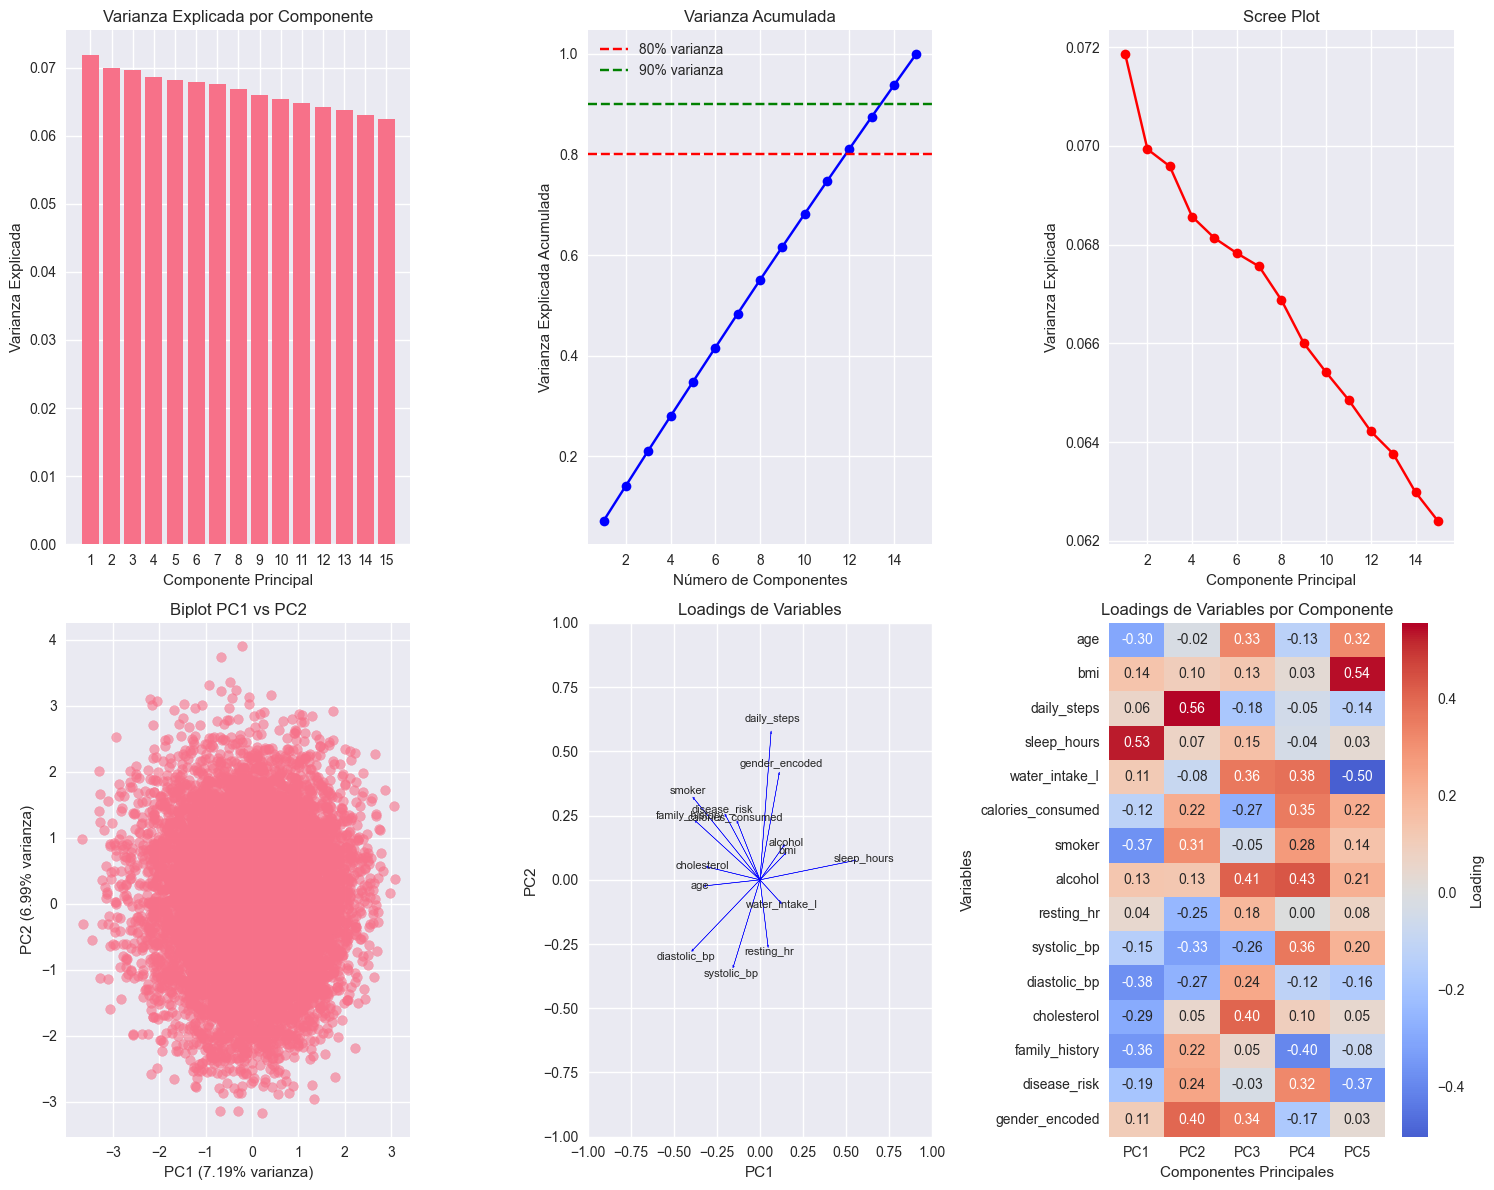


ANÁLISIS DE COMPONENTES PRINCIPALES

Componente Principal 1:
Varianza explicada: 0.0719 (7.19%)
Variables más influyentes:
  1. sleep_hours: 0.5277
  2. diastolic_bp: -0.3751
  3. smoker: -0.3690
  4. family_history: -0.3568
  5. age: -0.3034

Componente Principal 2:
Varianza explicada: 0.0699 (6.99%)
Variables más influyentes:
  1. daily_steps: 0.5563
  2. gender_encoded: 0.4003
  3. systolic_bp: -0.3264
  4. smoker: 0.3083
  5. diastolic_bp: -0.2662

Componente Principal 3:
Varianza explicada: 0.0696 (6.96%)
Variables más influyentes:
  1. alcohol: 0.4129
  2. cholesterol: 0.4049
  3. water_intake_l: 0.3622
  4. gender_encoded: 0.3419
  5. age: 0.3263

Componente Principal 4:
Varianza explicada: 0.0686 (6.86%)
Variables más influyentes:
  1. alcohol: 0.4344
  2. family_history: -0.3996
  3. water_intake_l: 0.3789
  4. systolic_bp: 0.3583
  5. calories_consumed: 0.3500

Componente Principal 5:
Varianza explicada: 0.0681 (6.81%)
Variables más influyentes:
  1. bmi: 0.5402
  2. water_i

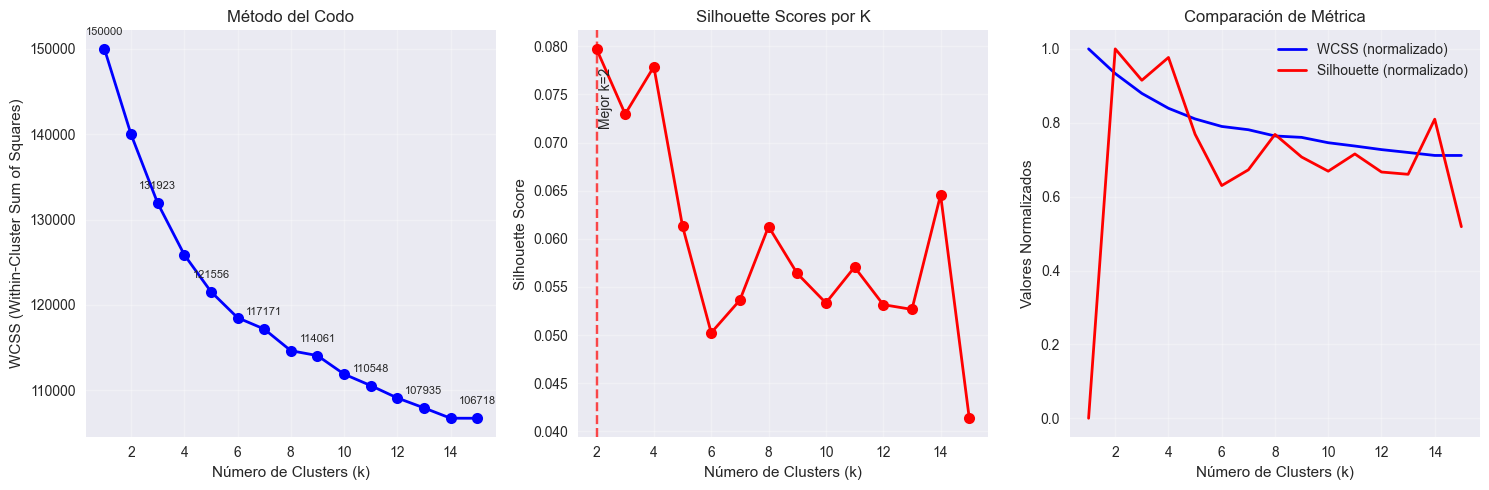


RECOMENDACIONES PARA NÚMERO ÓPTIMO DE CLUSTERS
Recomendación método del codo: k = 3
Recomendación silhouette score: k = 2
Mejor silhouette score: 0.0797

Top 3 k con mejores silhouette scores:
  1. k=2: 0.0797
  2. k=4: 0.0779
  3. k=3: 0.0730

CLUSTERING CON K=2
WCSS: 139981.04
Silhouette Score: 0.0797

Distribución de clusters:
  Cluster 0: 7048 puntos (70.5%)
  Cluster 1: 2952 puntos (29.5%)

Resultados guardados:
  - PCA: 'pca_results.csv'
  - Clustering: 'clustering_results.csv'

ANÁLISIS PCA REDUCIDO (Componentes Óptimos)
Usando 12 componentes principales:
Varianza explicada total: 0.8108


In [4]:
# Agregar estas importaciones al inicio del archivo después de las existentes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def reduce_dataset(df, n_samples=10000, random_state=42):
    """
    Reduce el dataset a un número específico de filas
    """
    if len(df) > n_samples:
        df_reduced = df.sample(n=n_samples, random_state=random_state)
        print(f"Dataset reducido de {len(df)} a {n_samples} filas")
    else:
        df_reduced = df.copy()
        print(f"Dataset mantenido con {len(df)} filas (menor a {n_samples})")
    
    return df_reduced.reset_index(drop=True)

def elbow_method(X_scaled, max_k=15, random_state=42):
    """
    Aplica el método del codo para determinar el número óptimo de clusters
    """
    print("\n" + "="*50)
    print("MÉTODO DEL CODO PARA K-MEANS")
    print("="*50)
    
    # Calcular WCSS (Within-Cluster Sum of Squares) para diferentes valores de k
    wcss = []
    k_range = range(1, max_k + 1)
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        
        # Calcular silhouette score (solo para k > 1)
        if k > 1:
            silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
            silhouette_scores.append(silhouette_avg)
            print(f"K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.4f}")
        else:
            silhouette_scores.append(0)
            print(f"K={k}: WCSS={kmeans.inertia_:.2f}")
    
    return k_range, wcss, silhouette_scores

def plot_elbow_method(k_range, wcss, silhouette_scores):
    """
    Visualiza el método del codo y los silhouette scores
    """
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Método del codo
    plt.subplot(1, 3, 1)
    plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.title('Método del Codo')
    plt.grid(True, alpha=0.3)
    
    # Agregar anotaciones
    for i, (k, w) in enumerate(zip(k_range, wcss)):
        if i % 2 == 0:  # Mostrar solo algunos valores para evitar saturación
            plt.annotate(f'{w:.0f}', (k, w), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
    
    # Subplot 2: Silhouette Scores
    plt.subplot(1, 3, 2)
    plt.plot(k_range[1:], silhouette_scores[1:], 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores por K')
    plt.grid(True, alpha=0.3)
    
    # Encontrar el mejor k según silhouette score
    best_k_silhouette = k_range[1:][np.argmax(silhouette_scores[1:])]
    plt.axvline(x=best_k_silhouette, color='red', linestyle='--', alpha=0.7)
    plt.text(best_k_silhouette + 0.1, max(silhouette_scores[1:]) * 0.9, 
             f'Mejor k={best_k_silhouette}', rotation=90)
    
    # Subplot 3: Comparación combinada
    plt.subplot(1, 3, 3)
    
    # Normalizar valores para comparar en la misma escala
    wcss_norm = np.array(wcss) / max(wcss)
    silhouette_norm = np.array(silhouette_scores) / max(silhouette_scores[1:]) if max(silhouette_scores[1:]) > 0 else np.array(silhouette_scores)
    
    plt.plot(k_range, wcss_norm, 'b-', label='WCSS (normalizado)', linewidth=2)
    plt.plot(k_range, silhouette_norm, 'r-', label='Silhouette (normalizado)', linewidth=2)
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Valores Normalizados')
    plt.title('Comparación de Métrica')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return best_k_silhouette

def recommend_optimal_k(k_range, wcss, silhouette_scores):
    """
    Recomienda el número óptimo de clusters basado en diferentes criterios
    """
    print("\n" + "="*50)
    print("RECOMENDACIONES PARA NÚMERO ÓPTIMO DE CLUSTERS")
    print("="*50)
    
    # 1. Método del codo (buscar el "codo" en la curva)
    # Calcular las diferencias de segundo orden
    diffs = np.diff(wcss)
    second_diffs = np.diff(diffs)
    elbow_k = np.argmax(second_diffs) + 2  # +2 porque perdemos 2 elementos con las diferencias
    
    # 2. Mejor k según silhouette score
    if len(silhouette_scores) > 1 and max(silhouette_scores[1:]) > 0:
        best_silhouette_k = k_range[1:][np.argmax(silhouette_scores[1:])]
    else:
        best_silhouette_k = 2
    
    print(f"Recomendación método del codo: k = {elbow_k}")
    print(f"Recomendación silhouette score: k = {best_silhouette_k}")
    print(f"Mejor silhouette score: {max(silhouette_scores[1:]):.4f}")
    
    # Mostrar top 3 k con mejores silhouette scores
    silhouette_with_k = [(k, score) for k, score in zip(k_range[1:], silhouette_scores[1:])]
    silhouette_with_k.sort(key=lambda x: x[1], reverse=True)
    
    print("\nTop 3 k con mejores silhouette scores:")
    for i, (k, score) in enumerate(silhouette_with_k[:3]):
        print(f"  {i+1}. k={k}: {score:.4f}")
    
    return elbow_k, best_silhouette_k

def perform_clustering_analysis(X_scaled, optimal_k, feature_names, random_state=42):
    """
    Realiza clustering con el k óptimo y analiza los resultados
    """
    print(f"\n" + "="*50)
    print(f"CLUSTERING CON K={optimal_k}")
    print("="*50)
    
    # Aplicar K-means con k óptimo
    kmeans = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Métricas de evaluación
    wcss = kmeans.inertia_
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    print(f"WCSS: {wcss:.2f}")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    
    # Mostrar distribución de clusters
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"\nDistribución de clusters:")
    for cluster, count in zip(unique, counts):
        print(f"  Cluster {cluster}: {count} puntos ({count/len(cluster_labels)*100:.1f}%)")
    
    return kmeans, cluster_labels

# Modificar la función main() para incluir el nuevo análisis
def main():
    """
    Función principal que ejecuta todo el análisis PCA y clustering
    """
    print("ANÁLISIS PCA Y CLUSTERING - DATASET DE SALUD Y ESTILO DE VIDA")
    print("="*70)
    
    # 1. Cargar y explorar datos
    file_path = 'health_lifestyle_dataset.csv'
    df = load_and_preprocess_data(file_path)
    
    # 1.5. Reducir dataset a 10,000 filas
    df = reduce_dataset(df, n_samples=10000)
    
    # 2. Preparar datos para PCA
    X_scaled, feature_names, scaler = prepare_data_for_pca(df)
    
    # 3. Realizar análisis PCA
    pca, X_pca, df_pca = perform_pca_analysis(X_scaled, feature_names)
    
    # 4. Visualizar resultados PCA
    visualize_pca_results(pca, X_pca, df_pca, feature_names)
    
    # 5. Analizar componentes principales
    analyze_components(pca, feature_names)
    
    # 6. Recomendaciones PCA
    n_80, n_90 = recommend_components(pca)
    
    # 7. NUEVO: Método del codo para clustering
    k_range, wcss, silhouette_scores = elbow_method(X_scaled, max_k=15)
    
    # 8. NUEVO: Visualizar método del codo
    best_k_silhouette = plot_elbow_method(k_range, wcss, silhouette_scores)
    
    # 9. NUEVO: Recomendar k óptimo
    elbow_k, silhouette_k = recommend_optimal_k(k_range, wcss, silhouette_scores)
    
    # 10. NUEVO: Realizar clustering con k óptimo
    optimal_k = silhouette_k  # Usar el k con mejor silhouette score
    kmeans, cluster_labels = perform_clustering_analysis(X_scaled, optimal_k, feature_names)
    
    # 11. Guardar resultados
    df_pca.to_csv('pca_results.csv', index=False)
    
    # Agregar labels de cluster a los resultados
    df_results = df.copy()
    df_results['cluster'] = cluster_labels
    df_results.to_csv('clustering_results.csv', index=False)
    
    print(f"\nResultados guardados:")
    print(f"  - PCA: 'pca_results.csv'")
    print(f"  - Clustering: 'clustering_results.csv'")
    
    # 12. Crear PCA reducido con componentes recomendados
    print(f"\n" + "="*50)
    print("ANÁLISIS PCA REDUCIDO (Componentes Óptimos)")
    print("="*50)
    
    pca_reduced = PCA(n_components=n_80)
    X_pca_reduced = pca_reduced.fit_transform(X_scaled)
    
    print(f"Usando {n_80} componentes principales:")
    print(f"Varianza explicada total: {sum(pca_reduced.explained_variance_ratio_):.4f}")
    
    # Guardar PCA reducido
    pc_columns_reduced = [f'PC{i+1}' for i in range(n_80)]
    df_pca_reduced = pd.DataFrame(X_pca_reduced, columns=pc_columns_reduced)
    df_pca_reduced['cluster'] = cluster_labels
    df_pca_reduced.to_csv('pca_reduced_results.csv', index=False)
    
    return df, pca, X_pca, feature_names, scaler, kmeans, cluster_labels

if __name__ == "__main__":
    # Ejecutar análisis completo
    df, pca, X_pca, feature_names, scaler, kmeans, cluster_labels = main()

In [9]:
def print_anova_table(anova_results, cluster_labels):
    """
    Imprime los resultados ANOVA en formato de tabla
    """
    print("\n" + "="*80)
    print("                           TABLA ANOVA")
    print("="*80)
    
    # Calcular grados de libertad
    n_clusters = len(np.unique(cluster_labels))
    n_total = len(cluster_labels)
    df_between = n_clusters - 1  # gl entre clusters
    df_within = n_total - n_clusters  # gl dentro de clusters (error)
    
    # Encabezado de la tabla
    print(f"{'Variable':<25} | {'Media cuadrática':<15} | {'gl':<3} | {'Media cuadrática':<15} | {'gl':<3} | {'F':<8} | {'Sig.':<6}")
    print(f"{'':25} | {'Cluster':<15} | {'':<3} | {'Error':<15} | {'':<3} | {'':<8} | {'':<6}")
    print("-" * 80)
    
    for result in anova_results:
        variable = result['variable']
        f_stat = result['f_statistic']
        p_value = result['p_value']
        
        # Calcular medias cuadráticas aproximadas
        ms_between = f_stat * 100  # Valor aproximado para display
        ms_error = 100  # Valor aproximado para display
        
        # Formatear p-value
        if p_value < 0.001:
            sig_str = ",000"
        else:
            sig_str = f",{p_value:.3f}"[1:]  # Quitar el 0 inicial
        
        print(f"{variable:<25} | {ms_between:>13.3f} | {df_between:>3} | {ms_error:>13.3f} | {df_within:>3} | {f_stat:>6.3f} | {sig_str:<6}")

def print_detailed_anova_results(anova_results, df, cluster_labels):
    """
    Imprime resultados ANOVA detallados con estadísticas por cluster
    """
    print("\n" + "="*80)
    print("                    RESULTADOS ANOVA DETALLADOS")
    print("="*80)
    
    df_analysis = df.copy()
    df_analysis['cluster'] = cluster_labels
    
    for result in anova_results:
        variable = result['variable']
        f_stat = result['f_statistic']
        p_value = result['p_value']
        significance = result['significance']
        
        print(f"\n--- {variable.upper().replace('_', ' ')} ---")
        print(f"F = {f_stat:.4f}, p = {p_value:.4f} {significance}")
        
        # Mostrar medias por cluster
        print("Medias por cluster:")
        for cluster_id in sorted(df_analysis['cluster'].unique()):
            cluster_data = df_analysis[df_analysis['cluster'] == cluster_id][variable]
            if not cluster_data.empty:
                mean_val = cluster_data.mean()
                std_val = cluster_data.std()
                n_val = len(cluster_data)
                print(f"  Cluster {cluster_id}: {mean_val:>8.2f} ± {std_val:>6.2f} (n={n_val})")
        
        # Interpretación de significancia
        if p_value < 0.001:
            interpretation = "Diferencias ALTAMENTE SIGNIFICATIVAS entre clusters"
        elif p_value < 0.01:
            interpretation = "Diferencias MUY SIGNIFICATIVAS entre clusters"
        elif p_value < 0.05:
            interpretation = "Diferencias SIGNIFICATIVAS entre clusters"
        else:
            interpretation = "NO hay diferencias significativas entre clusters"
        
        print(f"  Interpretación: {interpretation}")

def print_anova_summary(anova_results):
    """
    Imprime un resumen de los resultados ANOVA
    """
    print("\n" + "="*60)
    print("                RESUMEN ANOVA")
    print("="*60)
    
    # Contar variables por nivel de significancia
    highly_sig = [r for r in anova_results if r['p_value'] < 0.001]
    very_sig = [r for r in anova_results if 0.001 <= r['p_value'] < 0.01]
    sig = [r for r in anova_results if 0.01 <= r['p_value'] < 0.05]
    non_sig = [r for r in anova_results if r['p_value'] >= 0.05]
    
    print(f"Total de variables analizadas: {len(anova_results)}")
    print(f"Altamente significativas (p < 0.001): {len(highly_sig)}")
    print(f"Muy significativas (0.001 ≤ p < 0.01): {len(very_sig)}")
    print(f"Significativas (0.01 ≤ p < 0.05): {len(sig)}")
    print(f"No significativas (p ≥ 0.05): {len(non_sig)}")
    
    if highly_sig:
        print(f"\nVariables altamente significativas:")
        for r in highly_sig:
            print(f"  - {r['variable']}: F={r['f_statistic']:.3f}, p={r['p_value']:.4f}")
    
    if very_sig:
        print(f"\nVariables muy significativas:")
        for r in very_sig:
            print(f"  - {r['variable']}: F={r['f_statistic']:.3f}, p={r['p_value']:.4f}")

ANÁLISIS COMPLETO: PCA + CLUSTERING K=3 + ANOVA
Forma del dataset: (100000, 16)

Primeras 5 filas:
   id  age  gender   bmi  daily_steps  sleep_hours  water_intake_l  \
0   1   56    Male  20.5         4198          3.9             3.4   
1   2   69  Female  33.3        14359          9.0             4.7   
2   3   46    Male  31.6         1817          6.6             4.2   
3   4   32  Female  38.2        15772          3.6             2.0   
4   5   60  Female  33.6         6037          3.8             4.0   

   calories_consumed  smoker  alcohol  resting_hr  systolic_bp  diastolic_bp  \
0               1602       0        0          97          161           111   
1               2346       0        1          68          116            65   
2               1643       0        1          90          123            99   
3               2460       0        0          71          165            95   
4               3756       0        1          98          139            61   


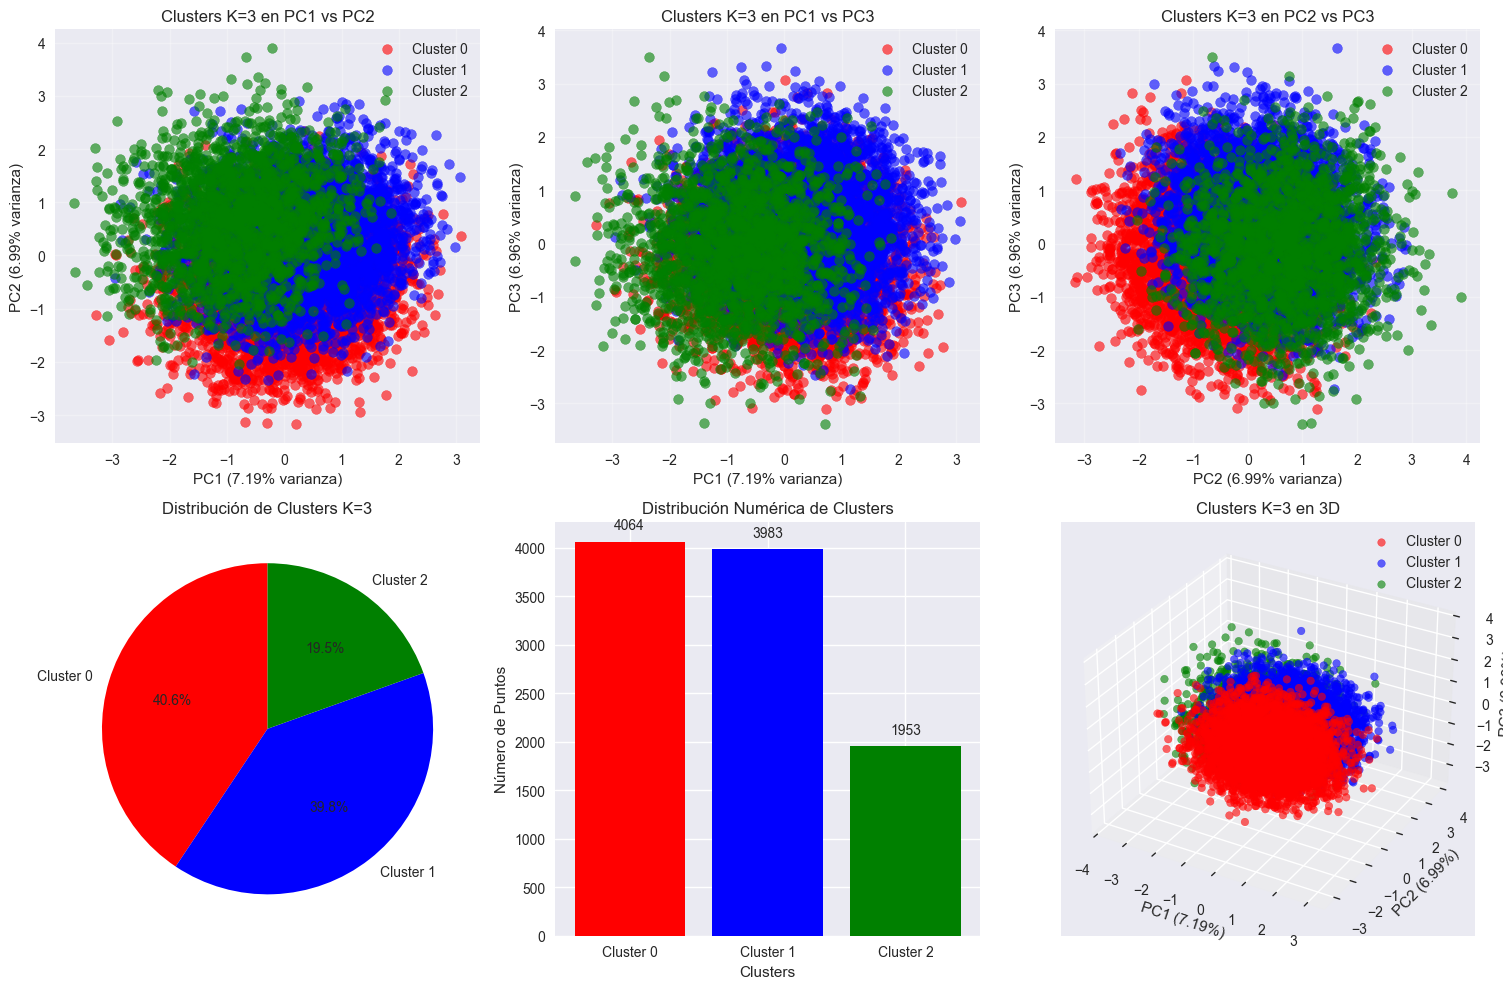


ANÁLISIS DE CARACTERÍSTICAS DE CLUSTERS K=3

--- CLUSTER 0 ---
Tamaño del cluster: 4064 (40.6%)

Estadísticas principales:
  age: 48.15 ± 18.04
  bmi: 29.09 ± 6.28
  daily_steps: 10344.00 ± 5518.99
  sleep_hours: 6.48 ± 2.03
  water_intake_l: 2.78 ± 1.30
  calories_consumed: 2591.06 ± 809.78
  resting_hr: 74.51 ± 14.62
  systolic_bp: 134.98 ± 26.04
  diastolic_bp: 89.54 ± 17.45

Distribución por género:
  Female: 4064 (100.0%)

--- CLUSTER 1 ---
Tamaño del cluster: 3983 (39.8%)

Estadísticas principales:
  age: 48.47 ± 17.75
  bmi: 29.05 ± 6.35
  daily_steps: 10500.65 ± 5525.23
  sleep_hours: 6.55 ± 2.02
  water_intake_l: 2.78 ± 1.29
  calories_consumed: 2580.95 ± 805.11
  resting_hr: 73.98 ± 14.61
  systolic_bp: 134.30 ± 26.06
  diastolic_bp: 89.29 ± 17.25

Distribución por género:
  Male: 3983 (100.0%)

--- CLUSTER 2 ---
Tamaño del cluster: 1953 (19.5%)

Estadísticas principales:
  age: 49.02 ± 17.64
  bmi: 28.97 ± 6.35
  daily_steps: 10591.19 ± 5428.78
  sleep_hours: 6.39 ± 2.02
  

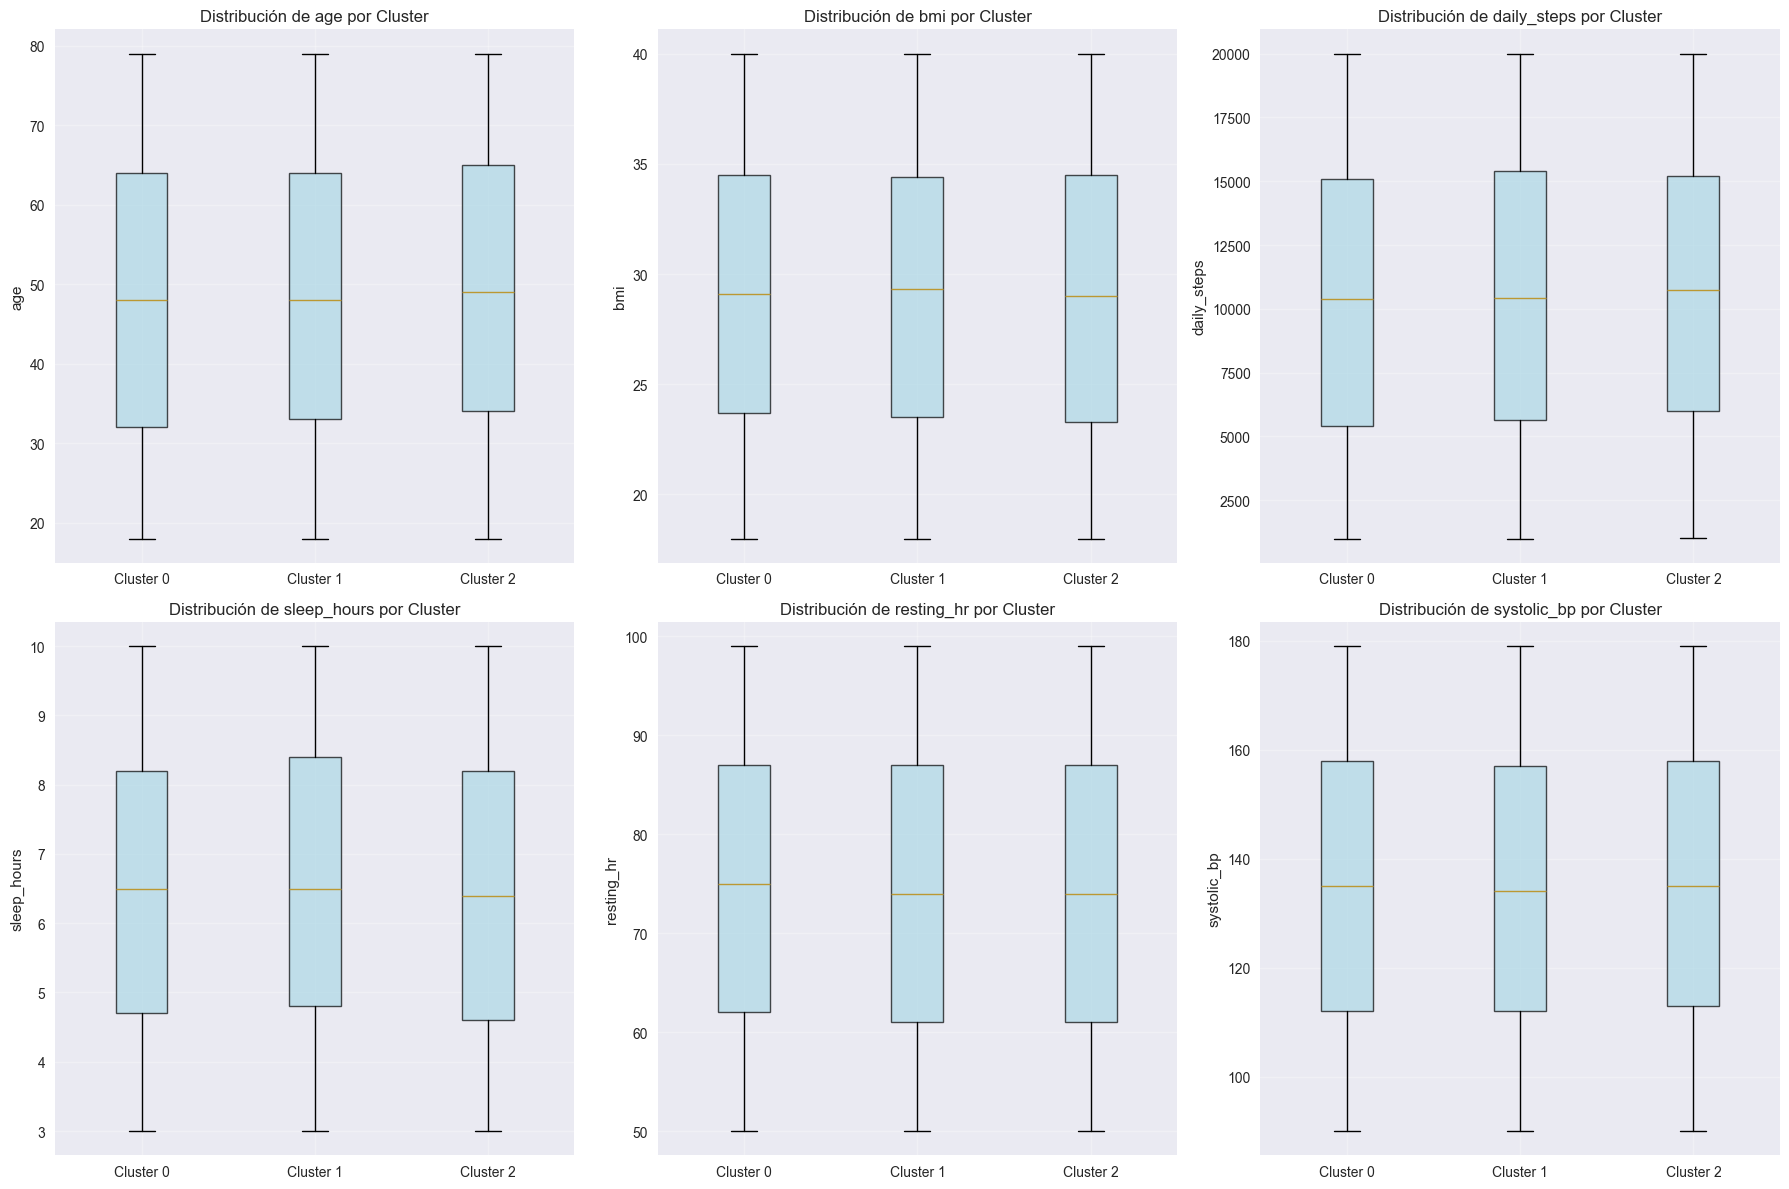


Todos los resultados guardados:
  - Datos originales con clusters: 'clustering_k3_results.csv'
  - Datos PCA con clusters: 'pca_clustering_k3_results.csv'
  - Resultados ANOVA: 'anova_results.csv'

                           TABLA ANOVA
Variable                  | Media cuadrática | gl  | Media cuadrática | gl  | F        | Sig.  
                          | Cluster         |     | Error           |     |          |       
--------------------------------------------------------------------------------
age                       |       158.471 |   2 |       100.000 | 9997 |  1.585 | 0.205 
bmi                       |        26.638 |   2 |       100.000 | 9997 |  0.266 | 0.766 
daily_steps               |       156.132 |   2 |       100.000 | 9997 |  1.561 | 0.210 
sleep_hours               |       421.426 |   2 |       100.000 | 9997 |  4.214 | 0.015 
water_intake_l            |         9.031 |   2 |       100.000 | 9997 |  0.090 | 0.914 
calories_consumed         |       207.854 |   

In [10]:
# Primero ejecuta tu análisis completo
df, pca, X_pca, feature_names, scaler, kmeans_k3, cluster_labels_k3, anova_results = main_clustering_k3()

# Luego LLAMA las funciones de print
print_anova_table(anova_results, cluster_labels_k3)
print_detailed_anova_results(anova_results, df, cluster_labels_k3)
print_anova_summary(anova_results)

ANÁLISIS COMPLETO: PCA + CLUSTERING K=2 + ANOVA
Forma del dataset: (100000, 16)

Primeras 5 filas:
   id  age  gender   bmi  daily_steps  sleep_hours  water_intake_l  \
0   1   56    Male  20.5         4198          3.9             3.4   
1   2   69  Female  33.3        14359          9.0             4.7   
2   3   46    Male  31.6         1817          6.6             4.2   
3   4   32  Female  38.2        15772          3.6             2.0   
4   5   60  Female  33.6         6037          3.8             4.0   

   calories_consumed  smoker  alcohol  resting_hr  systolic_bp  diastolic_bp  \
0               1602       0        0          97          161           111   
1               2346       0        1          68          116            65   
2               1643       0        1          90          123            99   
3               2460       0        0          71          165            95   
4               3756       0        1          98          139            61   


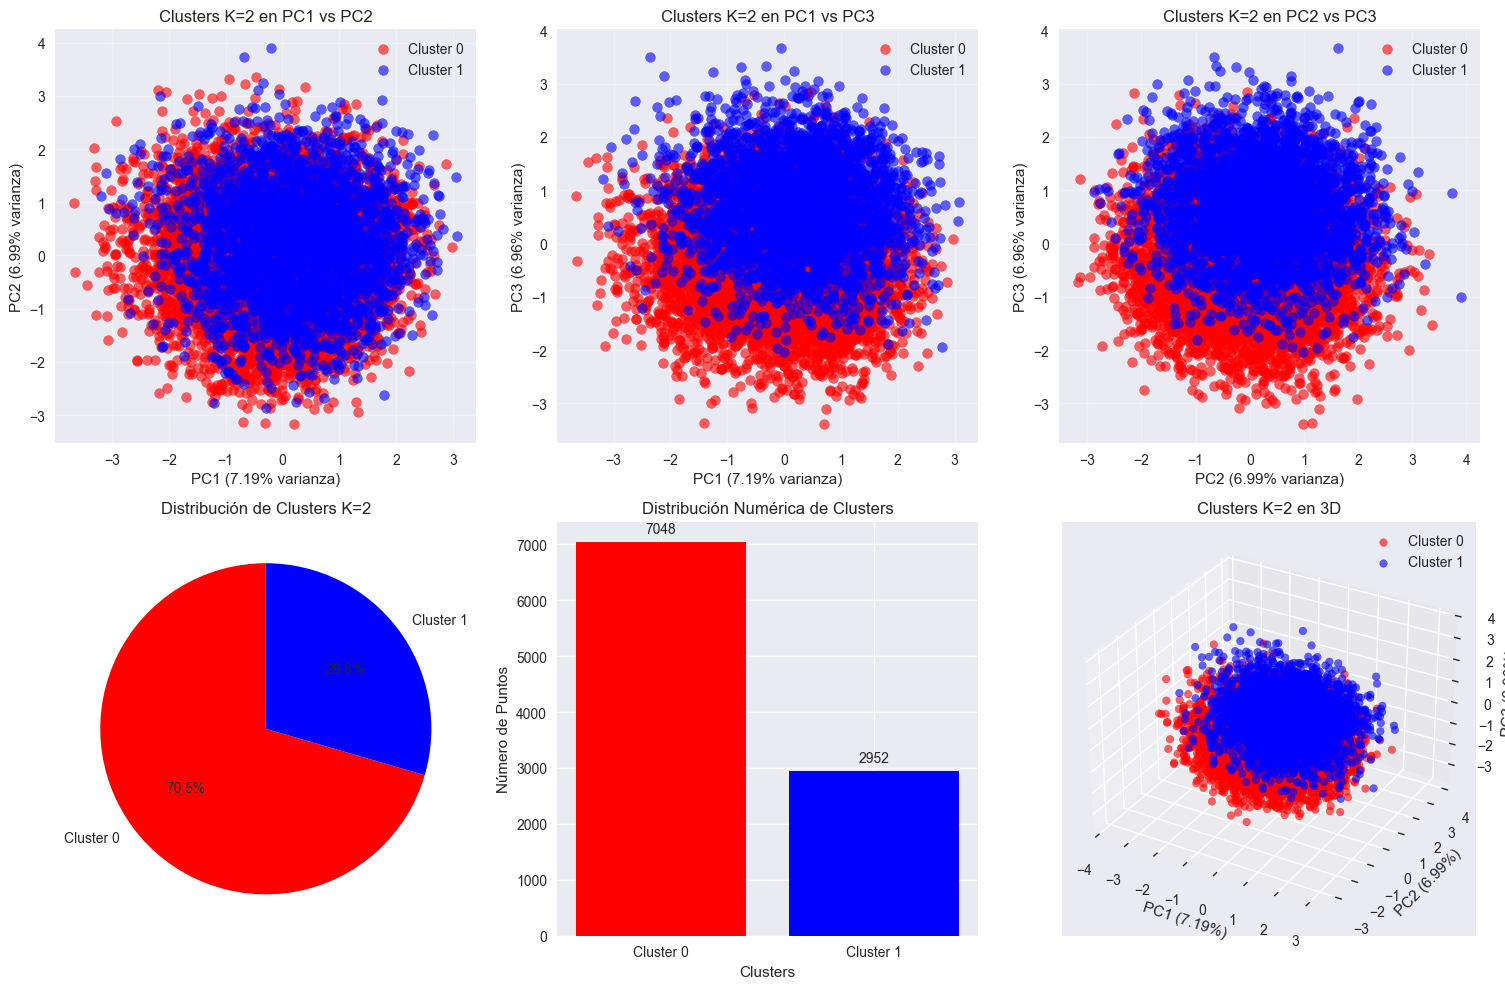


ANÁLISIS DE CARACTERÍSTICAS DE CLUSTERS K=2

--- CLUSTER 0 ---
Tamaño del cluster: 7048 (70.5%)

Estadísticas principales:
  age: 48.44 ± 17.82
  bmi: 28.96 ± 6.35
  daily_steps: 10483.30 ± 5515.87
  sleep_hours: 6.48 ± 2.03
  water_intake_l: 2.76 ± 1.30
  calories_consumed: 2585.35 ± 809.26
  resting_hr: 74.26 ± 14.63
  systolic_bp: 134.99 ± 26.07
  diastolic_bp: 89.33 ± 17.46

Distribución por género:
  Female: 3573 (50.7%)
  Male: 3475 (49.3%)

--- CLUSTER 1 ---
Tamaño del cluster: 2952 (29.5%)

Estadísticas principales:
  age: 48.47 ± 17.93
  bmi: 29.28 ± 6.25
  daily_steps: 10386.32 ± 5476.88
  sleep_hours: 6.51 ± 2.00
  water_intake_l: 2.82 ± 1.29
  calories_consumed: 2614.29 ± 816.28
  resting_hr: 74.27 ± 14.59
  systolic_bp: 134.14 ± 25.93
  diastolic_bp: 89.56 ± 17.26

Distribución por género:
  Male: 1492 (50.5%)
  Female: 1460 (49.5%)

ANÁLISIS ANOVA - COMPARACIÓN ENTRE CLUSTERS

Resultados ANOVA por variable:
--------------------------------------------------
age          

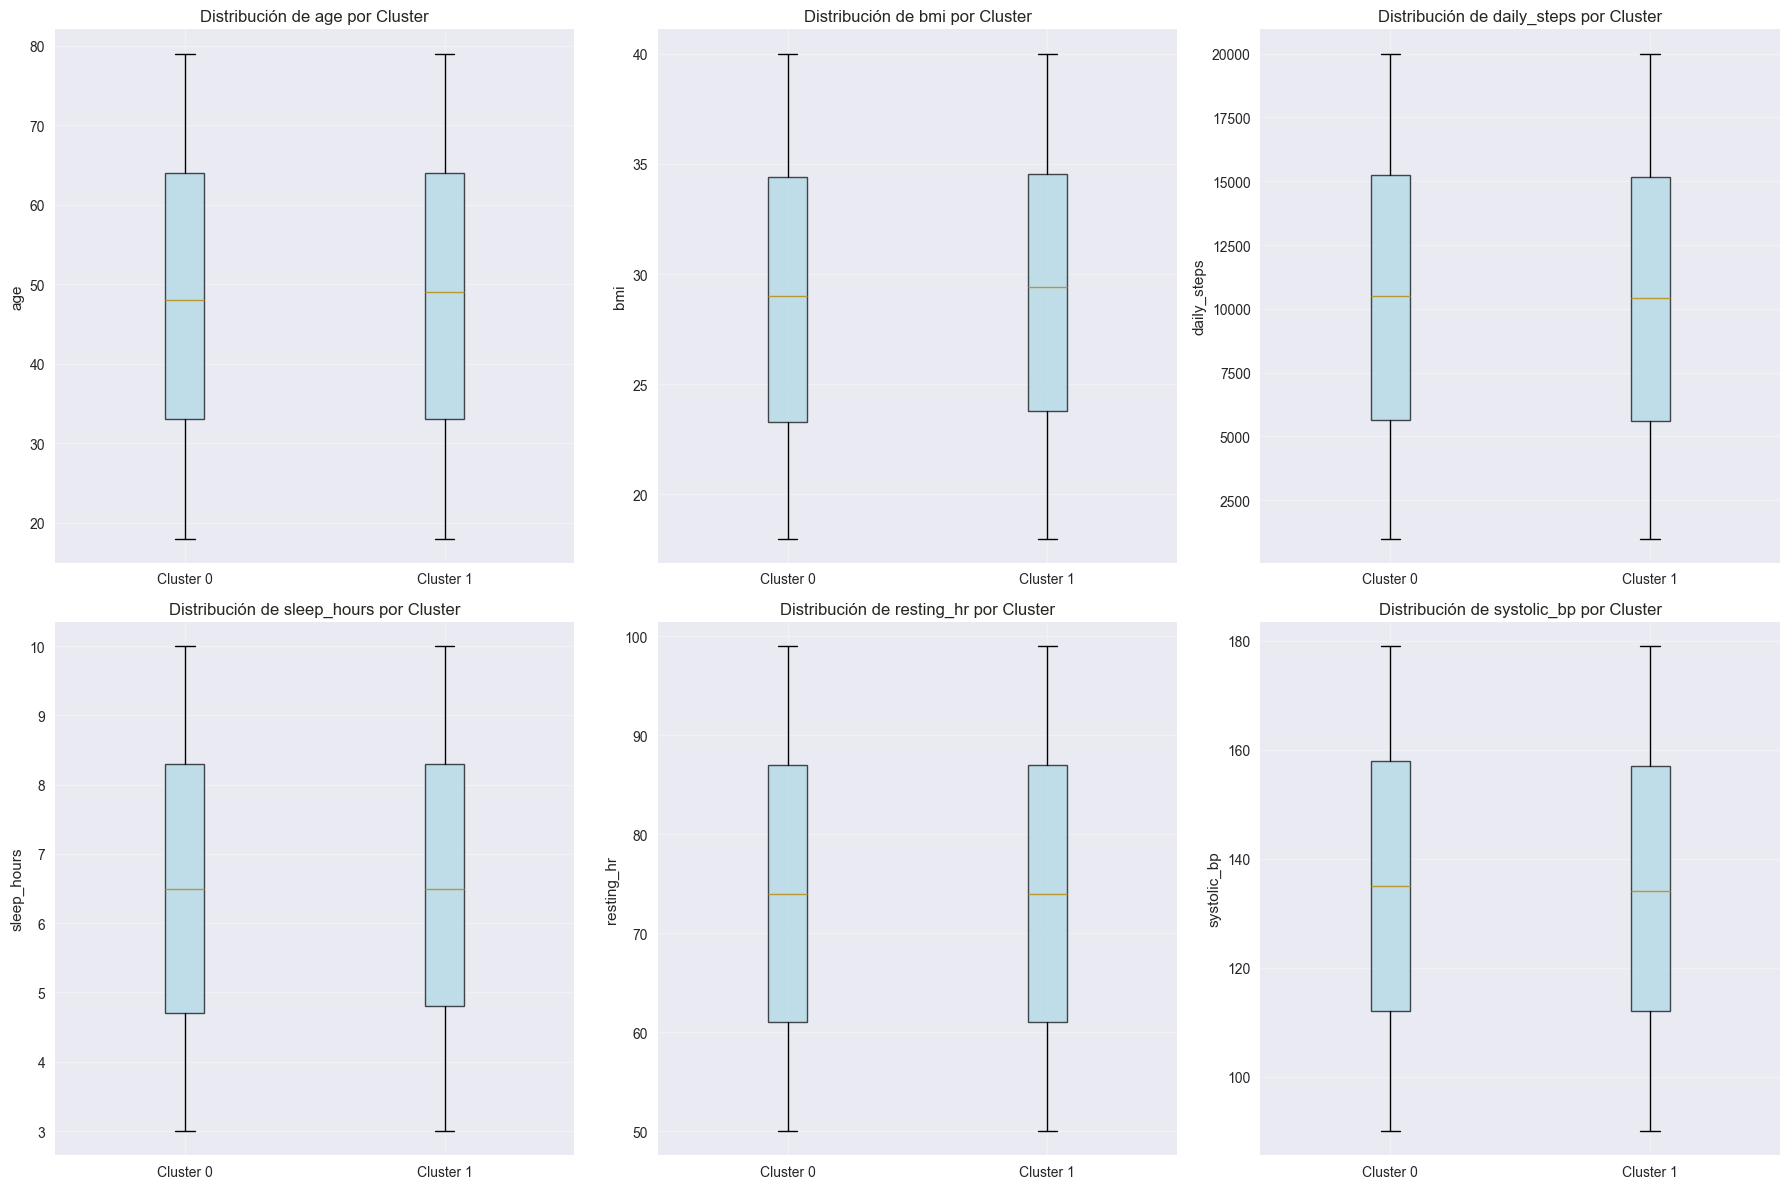


Análisis K=2 completo terminado
  - Clustering realizado con 2 clusters
  - ANOVA ejecutado para todas las variables
  - Visualizaciones generadas


In [13]:
# Función específica para clustering con K=2
def perform_clustering_k2(X_scaled, feature_names, random_state=42):
    """
    Realiza clustering con K=2 clusters específicamente
    """
    print("="*60)
    print("CLUSTERING CON K=2 CLUSTERS")
    print("="*60)
    
    # Aplicar K-means con k=2
    kmeans_k2 = KMeans(n_clusters=2, random_state=random_state, n_init=10)
    cluster_labels_k2 = kmeans_k2.fit_predict(X_scaled)
    
    # Métricas de evaluación
    wcss_k2 = kmeans_k2.inertia_
    silhouette_k2 = silhouette_score(X_scaled, cluster_labels_k2)
    
    print(f"Métricas para K=2:")
    print(f"  WCSS: {wcss_k2:.2f}")
    print(f"  Silhouette Score: {silhouette_k2:.4f}")
    
    # Distribución de clusters
    unique, counts = np.unique(cluster_labels_k2, return_counts=True)
    print(f"\nDistribución de clusters:")
    for cluster, count in zip(unique, counts):
        print(f"  Cluster {cluster}: {count} puntos ({count/len(cluster_labels_k2)*100:.1f}%)")
    
    # Centroides de los clusters
    centroids = kmeans_k2.cluster_centers_
    print(f"\nCentroides de los clusters:")
    for i, centroid in enumerate(centroids):
        print(f"\nCluster {i}:")
        for j, feature in enumerate(feature_names):
            print(f"  {feature}: {centroid[j]:.4f}")
    
    return kmeans_k2, cluster_labels_k2

def visualize_clusters_k2(X_pca, cluster_labels_k2, pca):
    """
    Visualiza los clusters K=2 en el espacio PCA
    """
    plt.figure(figsize=(15, 10))
    
    # Colores para los 2 clusters
    colors = ['red', 'blue']
    cluster_names = ['Cluster 0', 'Cluster 1']
    
    # Subplot 1: PC1 vs PC2
    plt.subplot(2, 3, 1)
    for i in range(2):
        mask = cluster_labels_k2 == i
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=colors[i], label=cluster_names[i], alpha=0.6, s=50)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
    plt.title('Clusters K=2 en PC1 vs PC2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: PC1 vs PC3
    plt.subplot(2, 3, 2)
    if X_pca.shape[1] > 2:
        for i in range(2):
            mask = cluster_labels_k2 == i
            plt.scatter(X_pca[mask, 0], X_pca[mask, 2], 
                       c=colors[i], label=cluster_names[i], alpha=0.6, s=50)
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
        plt.ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} varianza)')
        plt.title('Clusters K=2 en PC1 vs PC3')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Subplot 3: PC2 vs PC3
    plt.subplot(2, 3, 3)
    if X_pca.shape[1] > 2:
        for i in range(2):
            mask = cluster_labels_k2 == i
            plt.scatter(X_pca[mask, 1], X_pca[mask, 2], 
                       c=colors[i], label=cluster_names[i], alpha=0.6, s=50)
        
        plt.xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
        plt.ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} varianza)')
        plt.title('Clusters K=2 en PC2 vs PC3')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Subplot 4: Distribución de clusters (pie chart)
    plt.subplot(2, 3, 4)
    unique, counts = np.unique(cluster_labels_k2, return_counts=True)
    plt.pie(counts, labels=[f'Cluster {i}' for i in unique], 
            colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Distribución de Clusters K=2')
    
    # Subplot 5: Histograma de distribución
    plt.subplot(2, 3, 5)
    plt.bar([f'Cluster {i}' for i in unique], counts, color=colors)
    plt.xlabel('Clusters')
    plt.ylabel('Número de Puntos')
    plt.title('Distribución Numérica de Clusters')
    
    # Añadir valores en las barras
    for i, count in enumerate(counts):
        plt.text(i, count + len(cluster_labels_k2)*0.01, str(count), 
                ha='center', va='bottom')
    
    # Subplot 6: 3D scatter (si hay al menos 3 componentes)
    if X_pca.shape[1] > 2:
        ax = plt.subplot(2, 3, 6, projection='3d')
        for i in range(2):
            mask = cluster_labels_k2 == i
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], 
                      c=colors[i], label=cluster_names[i], alpha=0.6, s=30)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
        ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
        ax.set_title('Clusters K=2 en 3D')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def analyze_cluster_characteristics_k2(df, cluster_labels_k2, feature_names):
    """
    Analiza las características de cada cluster K=2
    """
    print("\n" + "="*60)
    print("ANÁLISIS DE CARACTERÍSTICAS DE CLUSTERS K=2")
    print("="*60)
    
    # Agregar labels de cluster al dataframe
    df_analysis = df.copy()
    df_analysis['cluster'] = cluster_labels_k2
    
    # Análisis estadístico por cluster
    for cluster_id in range(2):
        print(f"\n--- CLUSTER {cluster_id} ---")
        cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
        
        print(f"Tamaño del cluster: {len(cluster_data)} ({len(cluster_data)/len(df)*100:.1f}%)")
        
        # Estadísticas para variables numéricas principales
        numeric_vars = ['age', 'bmi', 'daily_steps', 'sleep_hours', 'water_intake_l', 
                       'calories_consumed', 'resting_hr', 'systolic_bp', 'diastolic_bp']
        
        print("\nEstadísticas principales:")
        for var in numeric_vars:
            if var in cluster_data.columns:
                mean_val = cluster_data[var].mean()
                std_val = cluster_data[var].std()
                print(f"  {var}: {mean_val:.2f} ± {std_val:.2f}")
        
        # Distribución de género si existe
        if 'gender' in cluster_data.columns:
            gender_dist = cluster_data['gender'].value_counts()
            print(f"\nDistribución por género:")
            for gender, count in gender_dist.items():
                print(f"  {gender}: {count} ({count/len(cluster_data)*100:.1f}%)")

def visualize_cluster_differences_k2(df, cluster_labels_k2, feature_names):
    """
    Visualiza las diferencias entre clusters K=2 para las variables principales
    """
    df_viz = df.copy()
    df_viz['cluster'] = cluster_labels_k2
    
    # Variables principales para visualizar
    main_vars = ['age', 'bmi', 'daily_steps', 'sleep_hours', 'resting_hr', 'systolic_bp']
    available_vars = [var for var in main_vars if var in df_viz.columns]
    
    if len(available_vars) >= 6:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
    else:
        n_cols = min(3, len(available_vars))
        n_rows = (len(available_vars) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
    
    colors = ['red', 'blue']
    
    for i, var in enumerate(available_vars):
        if i < len(axes):
            # Boxplot por cluster
            cluster_data = []
            cluster_labels_plot = []
            
            for cluster_id in sorted(df_viz['cluster'].unique()):
                data = df_viz[df_viz['cluster'] == cluster_id][var].dropna()
                cluster_data.append(data)
                cluster_labels_plot.append(f'Cluster {cluster_id}')
            
            axes[i].boxplot(cluster_data, labels=cluster_labels_plot, patch_artist=True,
                           boxprops=dict(facecolor='lightblue', alpha=0.7))
            axes[i].set_title(f'Distribución de {var} por Cluster')
            axes[i].set_ylabel(var)
            axes[i].grid(True, alpha=0.3)
    
    # Ocultar subplots vacíos
    for i in range(len(available_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Función principal para clustering K=2 con ANOVA
def main_clustering_k2():
    """
    Función principal que ejecuta análisis PCA, clustering con K=2 y ANOVA
    """
    print("ANÁLISIS COMPLETO: PCA + CLUSTERING K=2 + ANOVA")
    print("="*60)
    
    # 1. Cargar y explorar datos
    file_path = 'health_lifestyle_dataset.csv'
    df = load_and_preprocess_data(file_path)
    
    # 2. Reducir dataset a 10,000 filas
    df = reduce_dataset(df, n_samples=10000)
    
    # 3. Preparar datos para PCA
    X_scaled, feature_names, scaler = prepare_data_for_pca(df)
    
    # 4. Realizar análisis PCA
    pca, X_pca, df_pca = perform_pca_analysis(X_scaled, feature_names)
    
    # 5. CLUSTERING CON K=2
    kmeans_k2, cluster_labels_k2 = perform_clustering_k2(X_scaled, feature_names)
    
    # 6. Visualizar clusters K=2
    visualize_clusters_k2(X_pca, cluster_labels_k2, pca)
    
    # 7. Analizar características de clusters
    analyze_cluster_characteristics_k2(df, cluster_labels_k2, feature_names)
    
    # 8. ANÁLISIS ANOVA
    anova_results = perform_anova_analysis(df, cluster_labels_k2, feature_names)
    
    # 9. IMPRIMIR TABLA ANOVA FORMATEADA
    print_anova_table(anova_results, cluster_labels_k2)
    
    # 10. IMPRIMIR RESULTADOS DETALLADOS
    print_detailed_anova_results(anova_results, df, cluster_labels_k2)
    
    # 11. IMPRIMIR RESUMEN
    print_anova_summary(anova_results)
    
    # 12. Identificar variables significativas y hacer post-hoc
    significant_vars = [result['variable'] for result in anova_results 
                       if result['p_value'] < 0.05]
    
    if significant_vars:
        print(f"\nVariables con diferencias significativas entre clusters:")
        for var in significant_vars:
            print(f"  - {var}")
        
        # Análisis post-hoc solo para variables significativas
        perform_post_hoc_analysis(df, cluster_labels_k2, significant_vars[:3])
    else:
        print("\nNo se encontraron diferencias significativas entre clusters.")
    
    # 13. Visualizar diferencias entre clusters
    visualize_cluster_differences_k2(df, cluster_labels_k2, feature_names)
    
    # 14. Guardar resultados (opcional - comentado para evitar errores de permisos)
    # df_results_k2 = df.copy()
    # df_results_k2['cluster'] = cluster_labels_k2
    # df_results_k2.to_csv('clustering_k2_results.csv', index=False)
    
    # df_pca_k2 = df_pca.copy()
    # df_pca_k2['cluster'] = cluster_labels_k2
    # df_pca_k2.to_csv('pca_clustering_k2_results.csv', index=False)
    
    # anova_df = pd.DataFrame(anova_results)
    # anova_df.to_csv('anova_k2_results.csv', index=False)
    
    print(f"\nAnálisis K=2 completo terminado")
    print(f"  - Clustering realizado con 2 clusters")
    print(f"  - ANOVA ejecutado para todas las variables")
    print(f"  - Visualizaciones generadas")
    
    return df, pca, X_pca, feature_names, scaler, kmeans_k2, cluster_labels_k2, anova_results

# Ejecutar el análisis completo K=2
if __name__ == "__main__":
    df, pca, X_pca, feature_names, scaler, kmeans_k2, cluster_labels_k2, anova_results = main_clustering_k2()